In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv


In [2]:
# --- 1. LIBRARIES ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

warnings.filterwarnings('ignore')

In [3]:
# --- 2. DATA LOADING & OVERVIEW ---
# Load the dataset
df = pd.read_csv('/kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv')

# Get to know the data better
print(f"Dataset Shape: {df.shape}")
print("\n--- Data Info ---")
df.info()

Dataset Shape: (7043, 21)

--- Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 1

In [4]:
# --- 3. DATA CLEANING ---
# Drop irrelevant ID column
df.drop('customerID', axis=1, inplace=True)

# Fix TotalCharges (Convert to numeric)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Check missing values
print("\n--- Missing Values ---")
print(df.isnull().sum())

# Drop rows with missing values (only 11 rows)
df.dropna(inplace=True)


--- Missing Values ---
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64


In [5]:
# --- 4. FEATURE ENGINEERING (To Increase Accuracy) ---
# Creating new meaningful features helps the model learn better.

# Tenure Grouping (Binning)
def tenure_group(months):
    if months <= 12:
        return 0 # New
    elif months <= 24:
        return 1
    elif months <= 48:
        return 2
    elif months <= 60:
        return 3
    else:
        return 4 # Loyal

df['tenure_group'] = df['tenure'].apply(tenure_group)

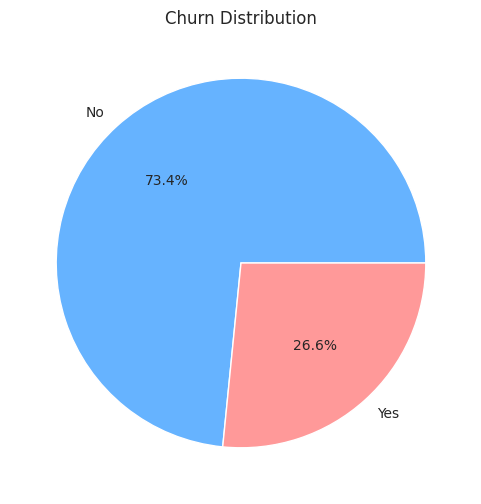

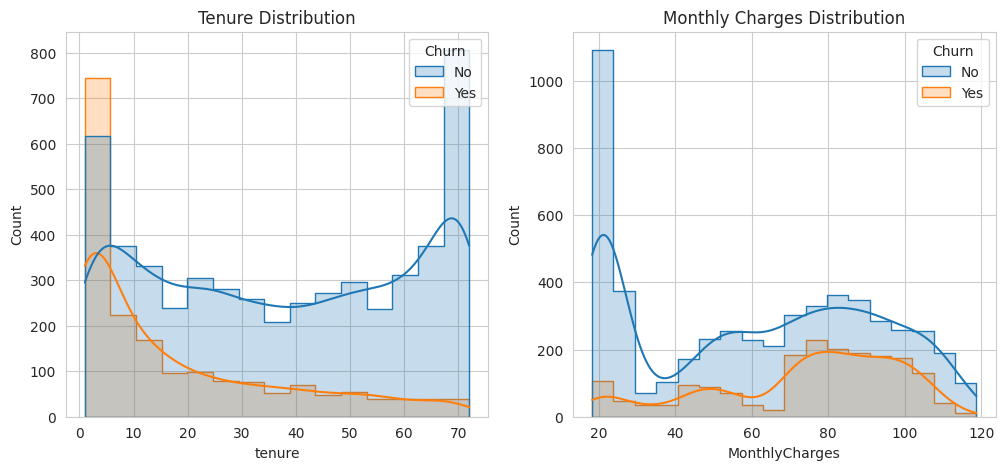

In [6]:
# --- 5. VISUALIZATION  ---
sns.set_style("whitegrid")

# Plot 1: Churn Distribution (Pie Chart)
plt.figure(figsize=(6,6))
df['Churn'].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=['#66b3ff','#ff9999'])
plt.title("Churn Distribution")
plt.ylabel('')
plt.show()

# Plot 2: Numerical Distributions (Histogram)
# Helps to understand customer behavior
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(data=df, x='tenure', hue='Churn', kde=True, element="step", ax=ax[0])
ax[0].set_title("Tenure Distribution")
sns.histplot(data=df, x='MonthlyCharges', hue='Churn', kde=True, element="step", ax=ax[1])
ax[1].set_title("Monthly Charges Distribution")
plt.show()


--- Encoding Categorical Columns ---
Encoded gender -> ['Female' 'Male']
Encoded Partner -> ['No' 'Yes']
Encoded Dependents -> ['No' 'Yes']
Encoded PhoneService -> ['No' 'Yes']
Encoded MultipleLines -> ['No' 'No phone service' 'Yes']
Encoded InternetService -> ['DSL' 'Fiber optic' 'No']
Encoded OnlineSecurity -> ['No' 'No internet service' 'Yes']
Encoded OnlineBackup -> ['No' 'No internet service' 'Yes']
Encoded DeviceProtection -> ['No' 'No internet service' 'Yes']
Encoded TechSupport -> ['No' 'No internet service' 'Yes']
Encoded StreamingTV -> ['No' 'No internet service' 'Yes']
Encoded StreamingMovies -> ['No' 'No internet service' 'Yes']
Encoded Contract -> ['Month-to-month' 'One year' 'Two year']
Encoded PaperlessBilling -> ['No' 'Yes']
Encoded PaymentMethod -> ['Bank transfer (automatic)' 'Credit card (automatic)' 'Electronic check'
 'Mailed check']
Encoded Churn -> ['No' 'Yes']


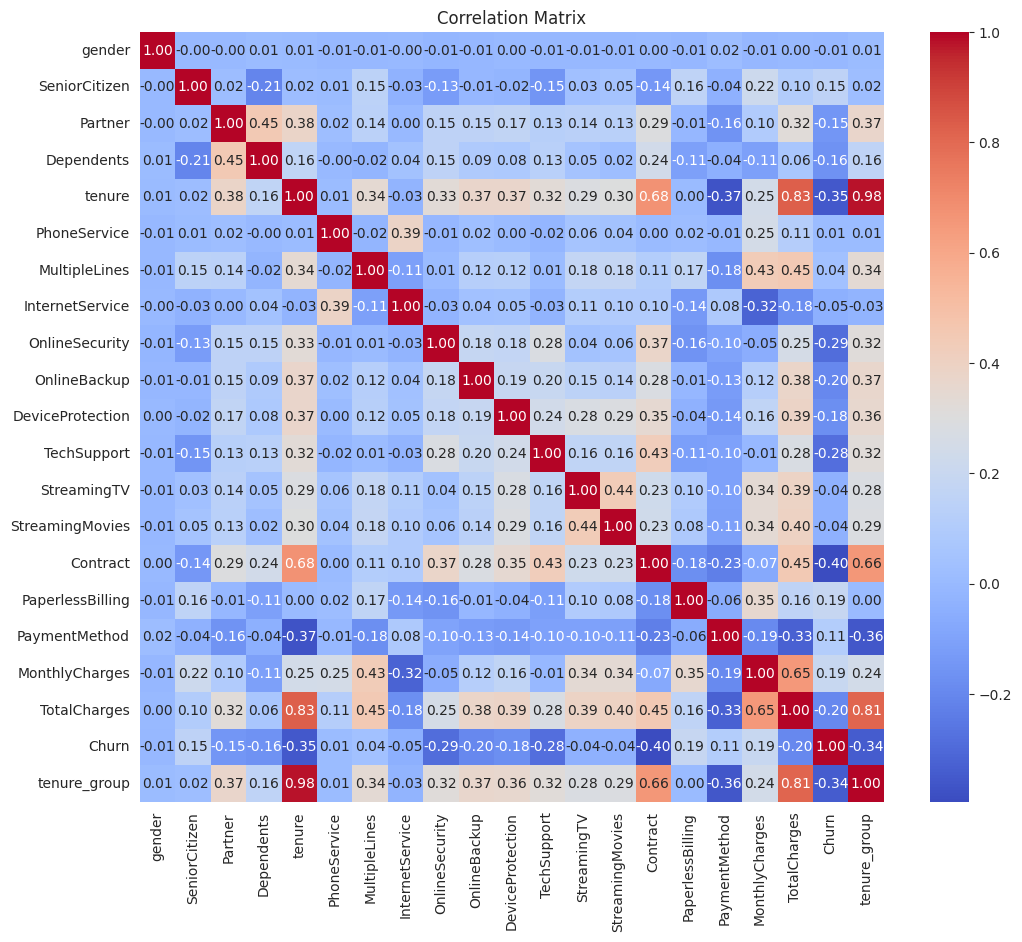

In [7]:
# --- 6. PREPROCESSING: LABEL ENCODING (Feedback 1) ---
# Instead of get_dummies, we use LabelEncoder.
# This keeps the dataframe size small and efficient.

categorical_cols = df.select_dtypes(include=['object']).columns
encoders = {} # We need to save these for the Streamlit App!

print("\n--- Encoding Categorical Columns ---")
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    encoders[col] = le # Save encoder
    print(f"Encoded {col} -> {le.classes_}")

# Plot 3: Correlation Matrix (Now possible for all columns) 
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

In [8]:
# --- 7. MODEL TRAINING (Optimized for Size & Accuracy) ---
X = df.drop('Churn', axis=1)
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(n_estimators=200, 
                               max_depth=12, 
                               min_samples_split=5,
                               min_samples_leaf=2,
                               random_state=42)

print("\nTraining Optimized Model (Lighter Version)...")
model.fit(X_train, y_train)


Training Optimized Model (Lighter Version)...


RandomForestClassifier(max_depth=12, min_samples_leaf=2, min_samples_split=5,
                       n_estimators=200, random_state=42)


✅ Model Accuracy: 79.53%

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.83      0.91      0.87      1033
           1       0.66      0.48      0.55       374

    accuracy                           0.80      1407
   macro avg       0.74      0.69      0.71      1407
weighted avg       0.78      0.80      0.78      1407



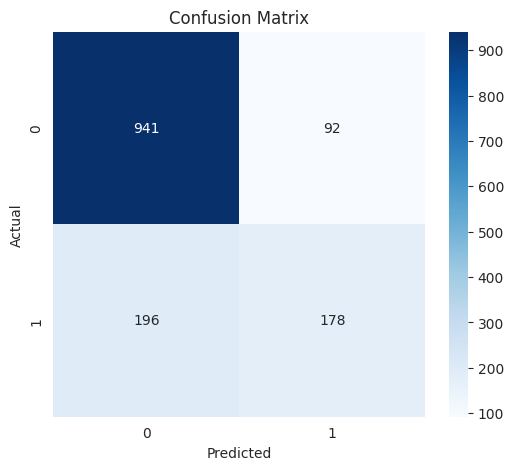

In [9]:
# --- 8. EVALUATION ---
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print(f"\n✅ Model Accuracy: {acc * 100:.2f}%")
print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred))

# Confusion Matrix
plt.figure(figsize=(6,5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [10]:
# --- 9. SAVE FILES ---
print("\nSaving files for Streamlit...")
pickle.dump(model, open('churn_model.pkl', 'wb'))
pickle.dump(encoders, open('encoders.pkl', 'wb'))
print("Files saved: 'churn_model.pkl' and 'encoders.pkl'")


Saving files for Streamlit...
Files saved: 'churn_model.pkl' and 'encoders.pkl'
